In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [24]:
def extract_folder(folderpath, add_scores=False, downsample=None):
    """
    Extract CSV data from folder and subfolders into a dataframe.

    Args:
      folderpath (str): Path to the folder containing CSV files.
      add_scores (bool, optional): Boolean to add scores.csv to the dataframe. Defaults to False.
      downsample (int, optional): Number of rows to downsample CSVs to. Defaults to None.

    Returns:
      pandas.DataFrame: DataFrame of concatenated CSV data.
    """
    
    # Dict to store dataframes by condition  
    dfs = {'control': [], 'condition': []}

    try:
        # Handle top-level scores CSV
        if add_scores and 'scores.csv' in os.listdir(folderpath):
            scores_path = os.path.join(folderpath, 'scores.csv')  
            dfs['scores'] = pd.read_csv(scores_path)

        # Get subfolders
        subfolders = [f for f in os.listdir(folderpath) if os.path.isdir(os.path.join(folderpath, f))]

        for subfolder in subfolders:
            subfolderpath = os.path.join(folderpath, subfolder)  

            # Get list of CSV files
            files = os.listdir(subfolderpath)

            for file in files:
                filepath = os.path.join(subfolderpath, file)

                # Extract ID from filename 
                id = file.split('.')[0]

                df = pd.read_csv(filepath)

                # Downsample if needed
                if downsample:
                    df = df.sample(downsample)

                # Add ID column - this is the filename without the extension
                df['id'] = id

                # Add 'condition' column
                df['condition'] = subfolder

                # Convert 'timestamp' and 'date' to datetime
                df['timestamp'] = pd.to_datetime(df['timestamp'])
                df['date'] = pd.to_datetime(df['date'])

                # Append to dict by condition
                if subfolder == 'control':
                    dfs['control'].append(df)
                else:  
                    dfs['condition'].append(df)

    except OSError:
        print(f"Error reading folder: {folderpath}")

    # concatenate dfs for each condition
    dfs['control'] = pd.concat(dfs['control'])
    dfs['condition'] = pd.concat(dfs['condition'])

    # Reset index on the final df
    df = pd.concat([dfs['control'], dfs['condition']]).reset_index(drop=True)

    # add label column
    df['label'] = 0
    df.loc[df['condition'] == 'condition', 'label'] = 1
    
    # remove old 'condition' column
    df.drop('condition', axis=1, inplace=True)

    # Final concat
    return df

## Exploratory data analysis (EDA)

In [47]:
# set folder path
folderpath = 'C:/Users/bouad/OneDrive/Bureau/depresjon/data'
# extract all files
all_files = extract_folder(folderpath, add_scores=True)
# print rows 21-24
#print(all_files.iloc[21:25])
print(all_files.head)


<bound method NDFrame.head of                   timestamp       date  activity           id  label
0       2003-03-18 15:00:00 2003-03-18        60    control_1      0
1       2003-03-18 15:01:00 2003-03-18         0    control_1      0
2       2003-03-18 15:02:00 2003-03-18       264    control_1      0
3       2003-03-18 15:03:00 2003-03-18       662    control_1      0
4       2003-03-18 15:04:00 2003-03-18       293    control_1      0
...                     ...        ...       ...          ...    ...
1571701 2004-06-10 15:03:00 2004-06-10         0  condition_9      1
1571702 2004-06-10 15:04:00 2004-06-10         0  condition_9      1
1571703 2004-06-10 15:05:00 2004-06-10       449  condition_9      1
1571704 2004-06-10 15:06:00 2004-06-10         0  condition_9      1
1571705 2004-06-10 15:07:00 2004-06-10         0  condition_9      1

[1571706 rows x 5 columns]>


In [43]:
def merge_dataframes(df, scores_df, merge_on_df='id', merge_on_scores='number', include_all_labels=False, save_to_csv=False, output_csv_path=None):
    try:
        # merge based on specified columns
        merged_df = pd.merge(df, scores_df, left_on=merge_on_df, right_on=merge_on_scores, how='left')
        # Fill missing values with NaN
        merged_df.fillna(value=pd.NA, inplace=True)

        # filter rows based on label
        if 'label' in merged_df.columns:
            if not include_all_labels:
                merged_df = merged_df[merged_df['label'] == 1]

        if save_to_csv:
            if output_csv_path:
                merged_df.to_csv(output_csv_path, index=False)
                print(f"Updated df saved to {output_csv_path}")
            else:
                print("Error: Please provide an output CSV path.")
        return merged_df
    except KeyError:
        print(f"Error: '{merge_on_df}' column not found in the specified DataFrames.")
        return merged_df




In [54]:
scores_df = pd.read_csv('C:/Users/bouad/OneDrive/Bureau/depresjon/data/scores.csv')
#print(scores_df)
merged_df = merge_dataframes(df, scores_df, merge_on_df='id', merge_on_scores='number')
print(merged_df)

                  timestamp       date  activity           id  label  \
1019990 2003-05-07 12:00:00 2003-05-07         0  condition_1      1   
1019991 2003-05-07 12:01:00 2003-05-07       143  condition_1      1   
1019992 2003-05-07 12:02:00 2003-05-07         0  condition_1      1   
1019993 2003-05-07 12:03:00 2003-05-07        20  condition_1      1   
1019994 2003-05-07 12:04:00 2003-05-07       166  condition_1      1   
...                     ...        ...       ...          ...    ...   
1571701 2004-06-10 15:03:00 2004-06-10         0  condition_9      1   
1571702 2004-06-10 15:04:00 2004-06-10         0  condition_9      1   
1571703 2004-06-10 15:05:00 2004-06-10       449  condition_9      1   
1571704 2004-06-10 15:06:00 2004-06-10         0  condition_9      1   
1571705 2004-06-10 15:07:00 2004-06-10         0  condition_9      1   

              number  days  gender    age  afftype  melanch  inpatient   edu  \
1019990  condition_1    11       2  35-39      2.0     

In [4]:
# Assuming all_files is already loaded from your previous function call
print(all_files.head())
print(all_files.describe())
print(all_files.info())



            timestamp       date  activity         id  label
0 2003-03-18 15:00:00 2003-03-18        60  control_1      0
1 2003-03-18 15:01:00 2003-03-18         0  control_1      0
2 2003-03-18 15:02:00 2003-03-18       264  control_1      0
3 2003-03-18 15:03:00 2003-03-18       662  control_1      0
4 2003-03-18 15:04:00 2003-03-18       293  control_1      0
                           timestamp                           date  \
count                        1571706                        1571706   
mean   2003-12-11 11:28:18.007070208  2003-12-10 23:28:14.226782464   
min              2002-05-24 11:30:00            2002-05-24 00:00:00   
25%              2003-04-01 02:07:00            2003-04-01 00:00:00   
50%              2003-11-27 19:06:00            2003-11-27 00:00:00   
75%              2004-03-08 18:07:00            2004-03-08 00:00:00   
max              2006-02-14 13:38:00            2006-02-14 00:00:00   
std                              NaN                            Na

In [5]:
# Print the column names of the DataFrame
print(all_files.columns)



Index(['timestamp', 'date', 'activity', 'id', 'label'], dtype='object')


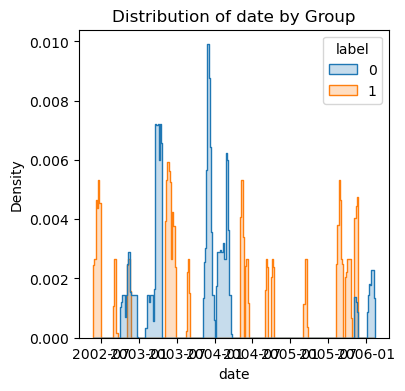

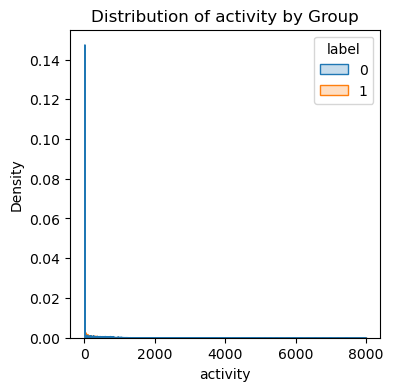

In [10]:

# Assuming 'age' and 'income' are columns in your DataFrame
numeric_cols = ['date', 'activity']  # Update this list with your actual numeric columns
for col in numeric_cols:
    plt.figure(figsize=(4, 4))
    sns.histplot(data=all_files, x=col, hue='label', element='step', stat='density', common_norm=False)
    plt.title(f'Distribution of {col} by Group')
    plt.show()


## preprocessing

In [ ]:
# Handling missing values
all_files.fillna(all_files.mean(), inplace=True)  # Using mean to fill numeric columns; adjust as needed

# Feature scaling (if needed, depending on your subsequent analysis methods)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
all_files[numeric_cols] = scaler.fit_transform(all_files[numeric_cols])

# Encoding categorical variables, if any
# If 'category_column' is a nominal categorical column
all_files = pd.get_dummies(all_files, columns=['category_column'], drop_first=True)


In [ ]:
# Assuming 'gender' is a column distinguishing male (coded as 0) and female (coded as 1)
grouped_by_gender = all_files.groupby('gender').mean()
print(grouped_by_gender)

# Visualize differences in a particular variable across gender within control and condition
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='your_numeric_col1', hue='label', data=all_files)
plt.title('Gender Comparison in Your_Numeric_Col1 Across Groups')
plt.show()
